In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

2025-04-12 11:29:36.864707: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-12 11:29:36.865551: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-12 11:29:36.868181: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-12 11:29:36.875776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744453776.888557 1306115 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744453776.89

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
data = pd.read_csv('../data/energy_data_cleaned.csv')

In [4]:

X = data.drop(['target', 'timestamp'], axis=1)
y = data['target']


In [5]:
# split in train 60%, validation 20 and test 20 sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# %% Scale target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

print('shape before reshaping')
print(y_train.shape)
print(y_train_scaled.shape)


shape before reshaping
(629007,)
(629007, 1)


In [6]:
def r2_metric(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())


In [7]:
def group_features(X):
    # Building characteristics features
    building_features = X[['square_feet', 'year_built', 'floor_count', 'm2_per_floor']].values
    
    # Temperature-related features (current and lagged)
    temp_cols = ['air_temperature'] + [col for col in X.columns if 'air_temperature_lag' in col]
    temperature_features = X[temp_cols].values
    
    # Target lag features
    target_lag_cols = [col for col in X.columns if 'target_lag' in col]
    target_lag_features = X[target_lag_cols].values
    
    # Primary use (categorical) features
    primary_use_cols = [col for col in X.columns if 'primary_use' in col]
    primary_use_features = X[primary_use_cols].values
    
    return building_features, temperature_features, target_lag_features, primary_use_features

In [8]:
train_building, train_temp, train_target_lag, train_primary_use = group_features(X_train)
val_building, val_temp, val_target_lag, val_primary_use = group_features(X_val)
test_building, test_temp, test_target_lag, test_primary_use = group_features(X_test)

In [9]:
def build_simple_multi_input_model(building_input_shape, temp_input_shape, 
                                 target_lag_input_shape, primary_use_input_shape):
    # Input layers
    building_input = Input(shape=(building_input_shape,), name='building_input')
    temp_input = Input(shape=(temp_input_shape,), name='temp_input')
    target_lag_input = Input(shape=(target_lag_input_shape,), name='target_lag_input')
    primary_use_input = Input(shape=(primary_use_input_shape,), name='primary_use_input')
    
    # Processamento simples para cada input
    x_building = Dense(32, activation='relu')(building_input)
    
    x_temp = Dense(32, activation='relu')(temp_input)
    
    x_target_lag = Dense(64, activation='relu')(target_lag_input)
    x_target_lag = Dropout(0.2)(x_target_lag)
    
    x_primary_use = Dense(16, activation='relu')(primary_use_input)
    
    # Combinar inputs
    combined = Concatenate()([x_building, x_temp, x_target_lag, x_primary_use])
    
    # Camadas compartilhadas simplificadas
    x = Dense(64, activation='relu')(combined)
    x = Dropout(0.2)(x)
    
    # Output layer
    output = Dense(1, activation='linear', name='output')(x)
    
    # Define o modelo
    model = Model(
        inputs=[building_input, temp_input, target_lag_input, primary_use_input],
        outputs=output
    )
    
    # Compila com configurações simples
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', r2_metric, 'mse']
    )
    
    return model


In [10]:
model = build_simple_multi_input_model(
    train_building.shape[1],
    train_temp.shape[1],
    train_target_lag.shape[1],
    train_primary_use.shape[1]
)
model.summary()

2025-04-12 11:29:40.674969: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_lag_input    │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ building_input      │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temp_input          │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │        448 │ target_lag_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ primary_use_input   │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        160 │ building_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        256 │ temp_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │         96 │ primary_use_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 144)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dropout[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      9,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,305 (40.25 KB)

 Trainable params: 10,305 (40.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=4, min_lr=0.00001, verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)


history = model.fit(
    [train_building, train_temp, train_target_lag, train_primary_use], y_train_scaled,
    validation_data=([val_building, val_temp, val_target_lag, val_primary_use], y_val_scaled),
    epochs=50,
    batch_size=64,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)


Epoch 1/50
9829/9829 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 714.1030 - mae: 8.1230 - mse: 714.1030 - r2_metric: -747.9368 - val_loss: 0.0700 - val_mae: 0.1839 - val_mse: 0.0700 - val_r2_metric: 0.9282 - learning_rate: 0.0010
Epoch 2/50
9829/9829 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.1714 - mae: 0.2980 - mse: 0.1714 - r2_metric: 0.8250 - val_loss: 0.0365 - val_mae: 0.1336 - val_mse: 0.0365 - val_r2_metric: 0.9627 - learning_rate: 0.0010
Epoch 3/50
9829/9829 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.1108 - mae: 0.2407 - mse: 0.1108 - r2_metric: 0.8868 - val_loss: 0.0360 - val_mae: 0.1384 - val_mse: 0.0360 - val_r2_metric: 0.9632 - learning_rate: 0.0010
Epoch 4/50
9829/9829 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.1019 - mae: 0.2301 - mse: 0.1019 - r2_metric: 0.8960 - val_loss: 0.0265 - val_mae: 0.1181 - val_mse: 0.0265 - val_r2_metric: 0.9728 - learning_rate: 0.0010
Epoch 5/50
9829/9829 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0981 - mae: 0.2245 - mse: 0.0981 - r2_metric

In [12]:
y_pred_scaled = model.predict([test_building, test_temp, test_target_lag, test_primary_use])
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Convert test data back to original scale too
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

# Métricas de desempenho
mae = mean_absolute_error(y_test_orig, y_pred)
mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orig, y_pred)

print(f"Test- MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")


6553/6553 ━━━━━━━━━━━━━━━━━━━━ 5s 772us/step
Test- MAE: 0.1213, MSE: 0.0448, RMSE: 0.2117, R2: 0.9830


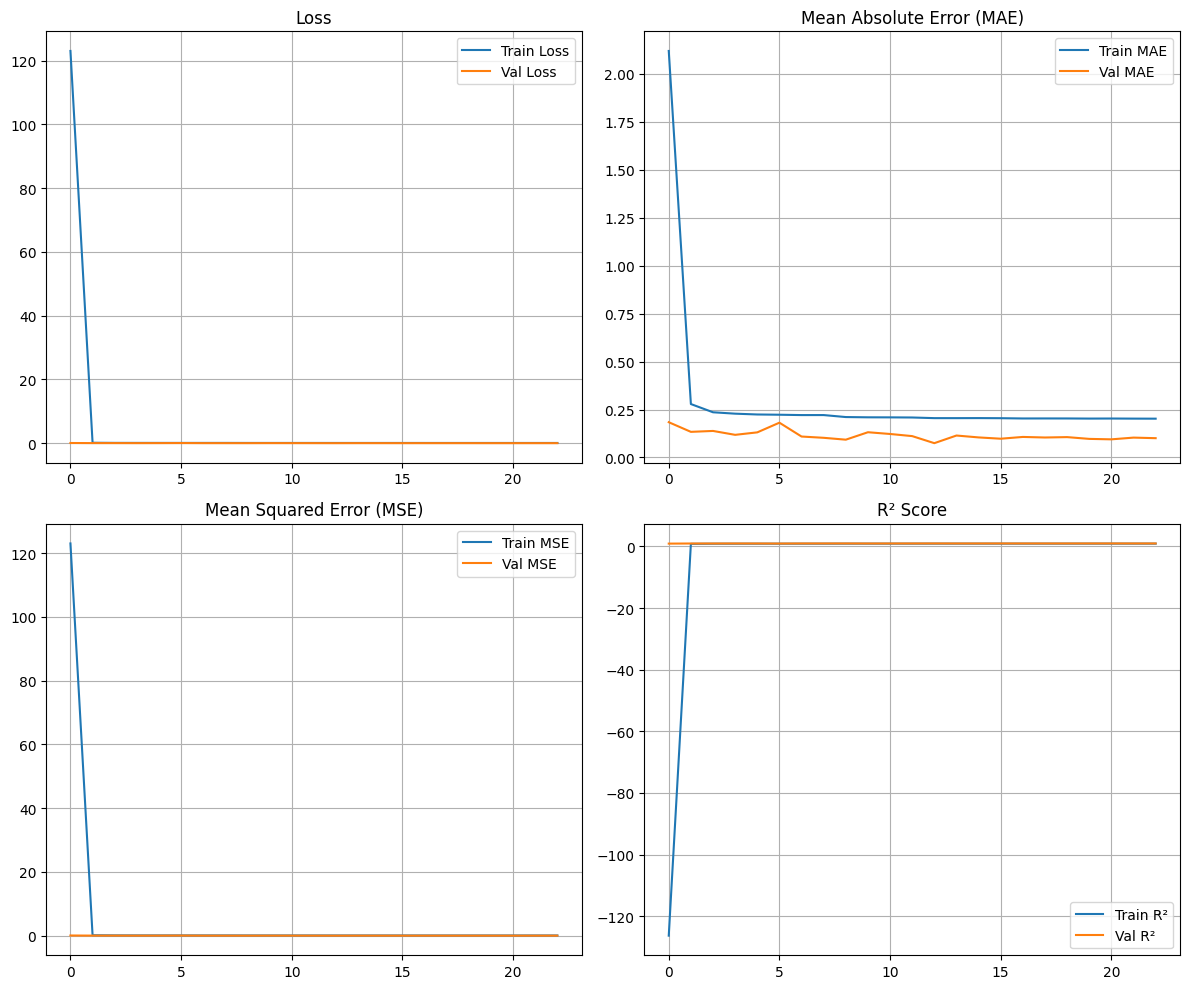

In [13]:
# Visualização do desempenho durante o treinamento
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.grid(True)

# Plot MAE
plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.grid(True)

# Plot MSE
plt.subplot(2, 2, 3)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.legend()
plt.title('Mean Squared Error (MSE)')
plt.grid(True)

# Plot R²
plt.subplot(2, 2, 4)
plt.plot(history.history['r2_metric'], label='Train R²')
plt.plot(history.history['val_r2_metric'], label='Val R²')
plt.legend()
plt.title('R² Score')
plt.grid(True)

plt.tight_layout()
plt.show()

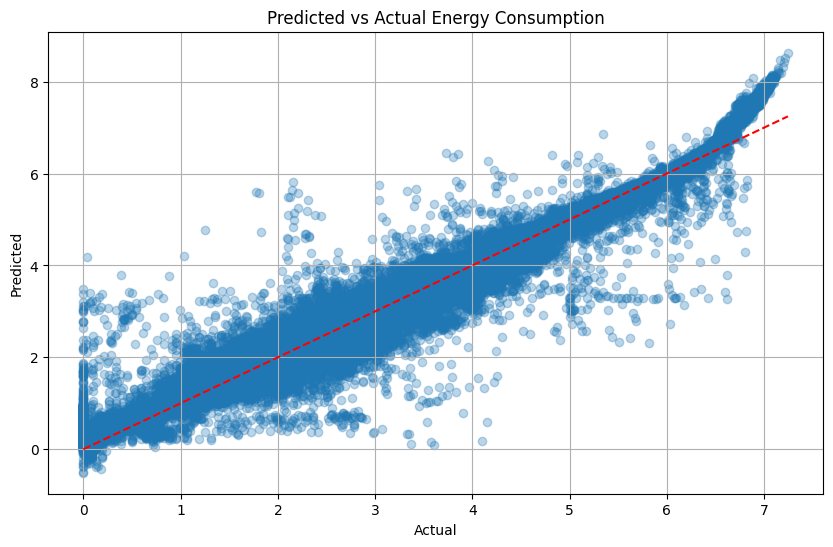

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_orig, y_pred, alpha=0.3)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Energy Consumption')
plt.grid(True)
plt.show()


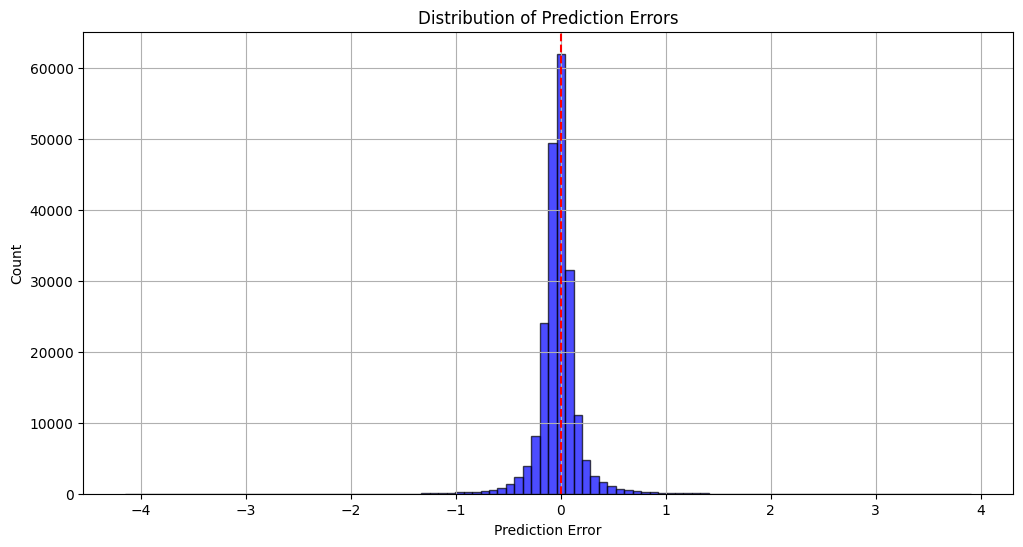

Error Analysis:
Mean Error: -0.0235
Standard Deviation of Error: 0.2104


In [15]:
# error analysis
error = y_test_orig - y_pred
plt.figure(figsize=(12, 6))
plt.hist(error, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()

print("Error Analysis:")
print(f"Mean Error: {np.mean(error):.4f}")
print(f"Standard Deviation of Error: {np.std(error):.4f}")

